In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2

In [2]:
import tensorflow as tf
from tensorflow import keras


In [3]:
train_dir='/media/adarshsrivastava/DATA/Face_mask/Train'
test_dir='/media/adarshsrivastava/DATA/Face_mask/Test'
validation_dir='/media/adarshsrivastava/DATA/Face_mask/Validation'

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)
validation_datagen=ImageDataGenerator(rescale=1./255)


In [5]:
train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=80,
    class_mode='binary'
)
validation_generator=validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128,128),
    batch_size=25,
    class_mode="binary"
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [6]:
from tensorflow.keras.applications import VGG19

conv_base=VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(128,128,3)
)

In [7]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [8]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [9]:
model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(2,activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 22,122,306
Trainable params: 22,122,306
Non-trainable params: 0
_________________________________________________________________


In [11]:
from tensorflow.keras import optimizers

In [12]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.RMSprop(1e-4),
              metrics=['acc'])

In [13]:
checkpoint_cb=keras.callbacks.ModelCheckpoint("maskdetection2-{epoch:02d}.h")

In [14]:
history=model.fit(train_generator,
                  steps_per_epoch=125,
                  epochs=5,
                  validation_data=validation_generator,
                  validation_steps=32,
                  callbacks=[checkpoint_cb]
                 )


Epoch 1/5
125/125 [==============================] - 2534s 20s/step - loss: 0.6576 - acc: 0.6425 - val_loss: 0.0975 - val_acc: 0.9688
INFO:tensorflow:Assets written to: maskdetection2-01.h/assets
Epoch 2/5
125/125 [==============================] - 2490s 20s/step - loss: 0.0384 - acc: 0.9841 - val_loss: 0.0163 - val_acc: 0.9962
INFO:tensorflow:Assets written to: maskdetection2-02.h/assets
Epoch 3/5
125/125 [==============================] - 2507s 20s/step - loss: 0.0232 - acc: 0.9930 - val_loss: 0.0574 - val_acc: 0.9900
INFO:tensorflow:Assets written to: maskdetection2-03.h/assets
Epoch 4/5
125/125 [==============================] - 2479s 20s/step - loss: 0.0285 - acc: 0.9928 - val_loss: 0.0075 - val_acc: 0.9975
INFO:tensorflow:Assets written to: maskdetection2-04.h/assets
Epoch 5/5
125/125 [==============================] - 2476s 20s/step - loss: 0.0276 - acc: 0.9950 - val_loss: 0.0077 - val_acc: 0.9987
INFO:tensorflow:Assets written to: maskdetection2-05.h/assets


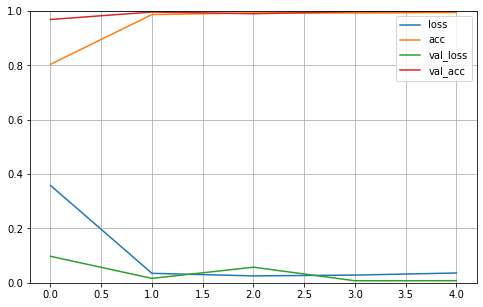

In [15]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [16]:
hist_df=pd.DataFrame(history.history)

In [17]:
hist_csv_file='histfacemask.csv'
with open(hist_csv_file,mode='w') as f:
    hist_df.to_csv(f)

In [18]:
test_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='binary'
)

Found 992 images belonging to 2 classes.


In [19]:
model.evaluate(test_generator,steps=31)

31/31 [==============================] - 61s 2s/step - loss: 0.0083 - acc: 0.9980


[0.008286037482321262, 0.9979838728904724]

In [32]:
face_clsfr=cv2.CascadeClassifier('/media/adarshsrivastava/DATA/Face_mask/haarcascade_frontalface_default.xml')
labels_dict={0:'with_mask',1:'without_mask'}
color_dict={0:(0,255,0),1:(0,0,255)}
size = 4
webcam=cv2.VideoCapture(0) #Use camera 0
# We load the xml file
classifier = cv2.CascadeClassifier('/media/adarshsrivastava/DATA/Face_mask/haarcascade_frontalface_default.xml')

while True:
    (rval, im) = webcam.read()
    im=cv2.flip(im,1,1) #Flip to act as a mirror
    
    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1]//size, im.shape[0]//size))
    
    # detect MultiScale / faces 
    faces = classifier.detectMultiScale(mini)
    
    # Draw rectangles around each face
    for f in faces:
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(128,128))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,128,128,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
        label=np.argmax(result,axis=1)[0]

        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    # Show the image
    cv2.imshow('LIVE',im)
    key = cv2.waitKey(10)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break
# Stop video
webcam.release()

# Close all started windows
cv2.destroyAllWindows()